In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import re
import torch

import collections

import numpy as np
import scipy.io
import scipy.ndimage

import PIL

import logging
logging.getLogger("PIL").setLevel(logging.INFO)

import common.plotting
import torch 
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import tensorflow

import os
import ot
import itertools
import datetime
import sys
from random import randint
from pyriemann.utils.distance import *
from common.plotting import plot_mat

os.environ['TORCH_MODEL_ZOO'] =  os.environ['PYTORCH_DATA_PATH']

In [3]:
def load_torch_config(filename):
    return torch.load('%s/%s' % (DST_CONFIG_DIR, filename))

def save_torch_config(data, filename):
    if not os.path.exists(DST_CONFIG_DIR):
        os.mkdir(DST_CONFIG_DIR)
    return torch.save(data, '%s/%s' % (DST_CONFIG_DIR, filename))

def load_torch_big_data(filename, samples):
    return torch.load('%s/%d/%s' % (DST_BIG_DATA_DIR, samples, filename))

def save_torch_big_data(data, filename, samples):
    if not os.path.exists(DST_BIG_DATA_DIR):
        os.mkdir(DST_BIG_DATA_DIR)
    if not os.path.exists('%s/%d' % (DST_BIG_DATA_DIR, samples)):
        os.mkdir('%s/%d' % (DST_BIG_DATA_DIR, samples))
    return torch.save(data, '%s/%d/%s' % (DST_BIG_DATA_DIR, samples, filename))

def to_np(x):
    if isinstance(x, Variable):
        x = x.data
    return x.cpu().numpy()

def to_variable(x, **kwargs):
    x = torch.from_numpy(x)
    if CUDA:
        x = x.cuda()
    return Variable(x, **kwargs)

def log(text):
    if not os.path.exists(DST_CONFIG_DIR):
        os.mkdir(DST_CONFIG_DIR)
    text = '%s | %s' % (datetime.datetime.now(), text)
    with open('%s/%s' % (DST_CONFIG_DIR, LOG_FILE), 'a') as file:
        file.write(text + '\n')
        file.flush()
    print(text)
    sys.stdout.flush()

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view((x.size(0), ) + self.shape)

In [4]:
import ot

def ground_matrix(n):
    x = []
    for i in range(n):
        for j in range(n):
            x.append([i, j])
    x = np.array(x)
    M = ot.dist(x, x, 'sqeuclidean')
    return M

def sqeuclidean_wasserstein_distance(x, y):
    x = to_np(x)
    y = to_np(y)
    M = ground_matrix(x.shape[1])
    x = x.reshape(x.shape[0], -1)
    y = y.reshape(y.shape[0], -1)
    return torch.Tensor([ot.emd2(x[i], y[i], M) for i in range(0, x.shape[0])])

def barycenter(x):
    x = x.double()
    x = to_np(x)
    M = ground_matrix(x.shape[1])
    reg = 1e-2
    x = x.reshape(x.shape[0], -1)
    x = numpy.swapaxes(x, 0, 1)
    return torch.Tensor([ot.barycenter(x, M, reg)])

In [5]:
def load_mnist(samples):
    log('start reading mnist data')
    
    try:
        log('read images, labels, distances from files')
        images = load_torch_big_data('images.pt', samples)
        labels = load_torch_big_data('labels.pt', samples)
        distances = load_torch_big_data('distances.pt', samples)
    except Exception as e:
        log('error, calucalting new data')
        data_path = os.environ.get('PYTORCH_DATA_PATH', '../data')

        dataset = torchvision.datasets.MNIST(data_path, train=True, download=True)
        imagesList = dataset.train_data
        imagesList = imagesList.squeeze(1).double()
        imagesList = imagesList.div(imagesList.sum(1).sum(1).unsqueeze(1).unsqueeze(1))
        labelsList = dataset.train_labels

        indexes = set()
        while len(indexes) < samples:
            indexes.add((randint(0, imagesList.size(0)-1), randint(0, imagesList.size(0)-1)))
        indexes = [j for i in list(indexes) for j in i]

        images = torch.index_select(imagesList, 0, torch.LongTensor(indexes))
        labels = torch.index_select(labelsList, 0, torch.LongTensor(indexes))
        images = images.view(-1, 2, images.size(1), images.size(2))
        labels = labels.view(-1, 2)
        distances = sqeuclidean_wasserstein_distance(images[:, 0], images[:, 1])

        images = images.float()
        distances = distances.float()

        save_torch_big_data(images, 'images.pt', samples)
        save_torch_big_data(labels, 'labels.pt', samples)
        save_torch_big_data(distances, 'distances.pt', samples)

    log('%d samples count' % images.size(0))
    log('distances sum: %.2f' % distances.sum())
    log('distances min: %.2f' % distances.min())
    log('distances max: %.2f' % distances.max())

    n_train = int(images.size(0) * 0.7)
    n_valid = int(images.size(0) * 0.9)
    train_images = images[:n_train]
    train_labels = labels[:n_train]
    train_distances = distances[:n_train]

    valid_images = images[n_train:n_valid]
    valid_labels = labels[n_train:n_valid]
    valid_distances = distances[n_train:n_valid]

    test_images = images[n_valid:]
    test_labels = labels[n_valid:]
    test_distances = distances[n_valid:]

    log('finish loading')
    return (train_images, train_labels, train_distances, valid_images, valid_labels, valid_distances, test_images, test_labels, test_distances)

In [6]:
def randIndex(classes):
    c = randint(0, len(classes) - 1)
    s = sum(x.size(0) for x in classes[:c])
    i = randint(0, classes[c].size(0) - 1)
    return s + i
    
def load_doodle(samples):
    log('start reading doodle data')
    
    try:
        log('read images, labels, distances from files')
        images = load_torch_big_data('images.pt', samples)
        labels = load_torch_big_data('labels.pt', samples)
        distances = load_torch_big_data('distances.pt', samples)
    except Exception as e:
        log('error, calucalting new data')
        data_path = os.environ.get('PYTORCH_DATA_PATH', '../data')

        catsImages = torch.from_numpy(np.load('/home/i233123/nn/nn_assignments/project/doodle/cat.npy')).view(-1, 28, 28)
        crabsImages = torch.from_numpy(np.load('/home/i233123/nn/nn_assignments/project/doodle/crab.npy')).view(-1, 28, 28)
        facesImages = torch.from_numpy(np.load('/home/i233123/nn/nn_assignments/project/doodle/face.npy')).view(-1, 28, 28)
        mnistImages = torchvision.datasets.MNIST(data_path, train=True, download=True).train_data

        catsImages = catsImages.double()
        crabsImages = crabsImages.double()
        facesImages = facesImages.double()
        mnistImages = mnistImages.squeeze(1).double()
        
        catsImages = catsImages.div(catsImages.sum(1).sum(1).unsqueeze(1).unsqueeze(1))
        crabsImages = crabsImages.div(crabsImages.sum(1).sum(1).unsqueeze(1).unsqueeze(1))
        facesImages = facesImages.div(facesImages.sum(1).sum(1).unsqueeze(1).unsqueeze(1))
        mnistImages = mnistImages.div(mnistImages.sum(1).sum(1).unsqueeze(1).unsqueeze(1))               
        
        imagesList = torch.cat((mnistImages, catsImages, crabsImages, facesImages), 0)
        labelsList = [0] * catsImages.size(0) + [1] * crabsImages.size(0) + [2] * facesImages.size(0) + [3] * mnistImages.size(0)
        labelsList = torch.Tensor(labelsList).int()
               
        indexes = set()
        while len(indexes) < samples:
            #i1 = randint(0, imagesList.size(0) - 1)
            #i2 = randint(0, imagesList.size(0) - 1)
            i1 = randIndex([catsImages, crabsImages, facesImages, mnistImages])
            i2 = randIndex([catsImages, crabsImages, facesImages, mnistImages])
            indexes.add((i1, i2))
        indexes = [j for i in list(indexes) for j in i]

        images = torch.index_select(imagesList, 0, torch.LongTensor(indexes))
        labels = torch.index_select(labelsList, 0, torch.LongTensor(indexes))
        images = images.view(-1, 2, images.size(1), images.size(2))
        labels = labels.view(-1, 2)
        distances = sqeuclidean_wasserstein_distance(images[:, 0], images[:, 1])

        images = images.float()
        distances = distances.float()

        save_torch_big_data(images, 'images.pt', samples)
        save_torch_big_data(labels, 'labels.pt', samples)
        save_torch_big_data(distances, 'distances.pt', samples)
        
    log('%d samples count' % images.size(0))
    log('distances sum: %.2f' % distances.sum())
    log('distances min: %.2f' % distances.min())
    log('distances max: %.2f' % distances.max())

    n_train = int(images.size(0) * 0.7)
    n_valid = int(images.size(0) * 0.9)
    train_images = images[:n_train]
    train_labels = labels[:n_train]
    train_distances = distances[:n_train]

    valid_images = images[n_train:n_valid]
    valid_labels = labels[n_train:n_valid]
    valid_distances = distances[n_train:n_valid]

    test_images = images[n_valid:]
    test_labels = labels[n_valid:]
    test_distances = distances[n_valid:]

    log('finish loading')
    return (train_images, train_labels, train_distances, valid_images, valid_labels, valid_distances, test_images, test_labels, test_distances)

In [7]:
def printMatrixDistancesLabels(distances, labels, classesCount):
    samples = distances.size(0)
    distances_matrix_sum = np.zeros((classesCount, classesCount))
    distances_matrix_count = np.zeros((classesCount, classesCount))

    for i in range(samples):
        l1 = max(labels[i])
        l2 = min(labels[i])
        distances_matrix_sum[l1][l2] += 2
        distances_matrix_sum[l1][l2] += distances[i]
        distances_matrix_count[l1][l2] += 1

    np.set_printoptions(precision=2)
    log('\n' + str(distances_matrix_sum))
    log('\n' + str(distances_matrix_count))
    log('\n' + str(distances_matrix_sum / distances_matrix_count))

#     from common.plotting import plot_mat
#     for i in range(10):
#         d = sqeuclidean_wasserstein_distance(images[i][0].unsqueeze(0), images[i][1].unsqueeze(0))[0]
#         lol = to_np(images[i])
#         lol = np.array([lol[0], lol[1]])
#         lol = np.expand_dims(lol, axis=1)
#         plot_mat(lol, cmap='gray')
#         plt.title("Distance: %.2f" % d)
#         show()

In [8]:
def compute_error_rate(model, allX, allY, batch_size):
    i = 0
    mse = 0.0
    while i < allX.size(0):
        x = Variable(allX[i:i+batch_size])
        y = Variable(allY[i:i+batch_size])
        if CUDA:
            x = x.cuda()
            y = y.cuda()
        (outputs, _) = model(x)
        diff = (outputs - y).data
        mse = mse + torch.sum(diff ** 2)
        i = i + batch_size
    return mse / allX.size(0)

def compute_prediction(model, allX, batch_size):
    i = 0
    y = torch.FloatTensor()
    if CUDA:
        y = y.cuda()
    while i < allX.size(0):
        x = Variable(allX[i:i+batch_size])
        if CUDA:
            x = x.cuda()
        y = torch.cat((y, model(x)[0].data), 0)
        i += batch_size
    return y

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(1, 20, kernel_size=3, padding=0),
                nn.ReLU()),
            nn.Sequential(
                nn.Conv2d(20, 10, kernel_size=3, padding=0),
                nn.ReLU()),
            nn.Sequential(
                nn.Conv2d(10, 5, kernel_size=5, padding=0),
                nn.ReLU()),
            Reshape(-1),
            nn.Sequential(
                nn.Linear(2000, 100),
                nn.ReLU()),
            nn.Sequential(
                nn.Linear(100, 50),
                nn.ReLU())
        )
        
        self.decoder = nn.Sequential(
            nn.Sequential(
                nn.Linear(50, 100),
                nn.ReLU()),
            nn.Sequential(
                nn.Linear(100, 5 * 32 * 32),
                nn.ReLU()),
            Reshape(5, 32, 32),
            nn.Sequential(
                nn.Conv2d(5, 10, kernel_size=1, padding=0),
                nn.ReLU()),
            nn.Sequential(
                nn.Conv2d(10, 20, kernel_size=3, padding=0),
                nn.ReLU()),
            nn.Sequential(
                nn.Conv2d(20, 1, kernel_size=3, padding=0),
                nn.ReLU()),
            Reshape(28 * 28),
            nn.Softmax(),
            Reshape(1, 28, 28)
        )
        
    def forward(self, data):
        data1 = data[:, 0].unsqueeze(1)
        encoder1 = self.encoder(data1)
        decoder1 = self.decoder(encoder1)
        #print(encoder1.size())
        #print(decoder1.sum(2).sum(2).unsqueeze(2).unsqueeze(2))
        
        data2 = data[:, 1].unsqueeze(1)
        encoder2 = self.encoder(data2)
        decoder2 = self.decoder(encoder2)
            
        encoder_difference = encoder1 - encoder2
        encoder_factor = torch.torch.matmul(encoder_difference, encoder_difference.transpose(0, 1)).diag()
        
        return (encoder_factor, torch.cat((decoder1, decoder2)))
      
def loadModel(model):
    try:
        log('load model')
        model.load_state_dict(load_torch_config('cnn.pkl'))
        log('load model finished')
    except:
        log('load model error')

def trainModel(model, train_images, train_distances, valid_images, valid_distances, learning_rate, samples, batch_size, restore):
    log('start training')

    epoch = 0
    num_epochs = 1
    patience_expansion = 1.5
    best_value_error = 1000000.0
    best_params = None

    mse_criterion = nn.MSELoss()
    kl_criterion = nn.KLDivLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if restore:
        try:
            log('restore training data')
            model.load_state_dict(load_torch_config('cnn.pkl'))
            optimizer.load_state_dict(load_torch_config('optimizer.pkl'))
            e = load_torch_config('epoch.pkl')
            epoch = e[0]
            num_epochs = e[1]
            log('restore training data finished')
        except:
            log('restore training data error')
    
    try:
        while epoch < num_epochs:
            epoch += 1
            i = 0
            while i < train_images.size(0):
                optimizer.zero_grad()
                x = Variable(train_images[i:i+batch_size])
                y = Variable(train_distances[i:i+batch_size])
                if CUDA:
                    x = x.cuda()
                    y = y.cuda()
                (distances_outputs, images_outputs) = model(x)
#                 print(images_outputs)
#                 print(x)
                loss1 = mse_criterion(distances_outputs, y)
                loss2 = kl_criterion(images_outputs, x)
                loss = loss1 + loss2
                loss.backward()
                optimizer.step()
                i = i + batch_size

            value_error = compute_error_rate(model, valid_images, valid_distances, batch_size)
            if (value_error < best_value_error):
                best_value_error = value_error
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_params = [p.clone().cpu() for p in model.parameters()]

            log('epoch [%d/%d]' % (epoch, num_epochs))
            log('validation set errors: %.2f' % value_error)
            log('')

            save_torch_config(model.state_dict(), 'cnn.pkl')
            save_torch_config(optimizer.state_dict(), 'optimizer.pkl')
            save_torch_config(torch.Tensor([epoch, num_epochs]), 'epoch.pkl')

            with open('%s/%s' % (DST_CONFIG_DIR, CONFIG_FILE), 'w') as file:
                file.write("samples            %d\n" % (samples))
                file.write("num_epochs         %d\n" % (num_epochs))
                file.write("epoch              %d\n" % (epoch))
                file.write("batch_size         %d\n" % (batch_size))
                file.write("patience_expansion %.4f\n" % (patience_expansion))
                file.write("best_value_error   %.4f\n" % (best_value_error))
                file.write("learning_rate      %.8f\n" % (learning_rate))
                file.flush()

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        model.parameters = best_params
        
    save_torch_config(model.state_dict(), 'cnn.pkl')
    save_torch_config(optimizer.state_dict(), 'optimizer.pkl')    

    log('finish training')
    
def plotScatter(title, model, x, y, batch_size):
    exact = np.arange(0.0, 45.0, step=0.1)
    error = compute_error_rate(model, x, y, batch_size)
    log('MSE = %.2f' % error)
    _, sorted_indices = torch.sort(y)
    y1 = to_np(torch.index_select(y, 0, sorted_indices))
    y2 = to_np(torch.index_select(compute_prediction(model, x, batch_size).cpu(), 0, sorted_indices))

    mean1 = np.array([])
    mean2 = np.array([])
    p10_1 = np.array([])
    p10_2 = np.array([])
    p90_1 = np.array([])
    p90_2 = np.array([])
    
    for x in np.arange(1.25, 46.25, 2.5):
        ind = (x - 1.25 < y1) & (y1 < x + 1.25)
        diffY = y1[ind] - y2[ind]
        if diffY.shape[0] == 0:
            continue
        error_value = (diffY ** 2).mean()
        mean1 = np.append(mean1, x)
        mean2 = np.append(mean2, x - error_value)
        
        p10_1 = np.append(p10_1, x)
        p10_2 = np.append(p10_2, x - np.percentile(diffY, 10))
        
        p90_1 = np.append(p90_1, x)
        p90_2 = np.append(p90_2, x - np.percentile(diffY, 90))
        
    fig = plt.figure(figsize = (10, 8))
    plt.plot(exact, exact, '-', label = 'Exact prediction')
    plt.plot(mean1, mean2, '-x', label = 'Mean prediction')
    plt.plot(p10_1, p10_2, '-x', label = '10th percentile')
    plt.plot(p90_1, p90_2, '-x', label = '90th percentile')
    plt.ylabel('Predicted Wass. distance')
    plt.xlabel('True Wass. distance')
    plt.title(title + 'MSE=%.2f' % error)
    plt.legend()
    plt.grid(True)
    show()

In [10]:
def plotBarycenters(model, testImages, testLabels, classes, count=1000):
    images = [torch.FloatTensor()] * classes
    for i in range(testLabels.size(0)):
        i1 = testLabels[i][0]
        i2 = testLabels[i][1]
        try:
            if images[i1].size(0) < count:
                images[i1] = torch.cat((images[i1], testImages[i][0].unsqueeze(0)), 0)
        except:
            images[i1] = torch.cat((images[i1], testImages[i][0].unsqueeze(0)), 0)
            
        try:
            if images[i2].size(0) < count:
                images[i2] = torch.cat((images[i2], testImages[i][1].unsqueeze(0)), 0)
        except:
            images[i2] = torch.cat((images[i2], testImages[i][1].unsqueeze(0)), 0)

    l2 = np.array([]).reshape(0, 28, 28)
    for c in range(classes):
        weights = np.array([1.0 / images[c].size(0)] * images[c].size(0))
        l2 = np.append(l2, [to_np(images[c]).T.dot(weights).T], axis=0)
    l2 = np.expand_dims(l2, axis=1)
    plot_mat(l2, cmap='gray')
    plt.title("L2")
    show()
        
    w = torch.FloatTensor()
    for c in range(classes):
        data = Variable(images[c].unsqueeze(1))
        if CUDA:
            data = data.cuda()
        data = model.encoder(data)
        weights = Variable(torch.Tensor([1.0 / data.size(0)] * data.size(0)).unsqueeze(1))
        if CUDA:
            weights = weights.cuda()
        data = torch.t(torch.matmul(torch.t(data), weights))
        data = model.decoder(data)
        data = data.data.squeeze(1)
        
        if CUDA:
            data = data.cpu()
        w = torch.cat((w, data), 0)
    w = np.expand_dims(to_np(w), axis=1)
    plot_mat(w, cmap='gray')
    plt.title("DWE")
    show()

2018-01-29 03:12:02.941536 | start reading mnist data
2018-01-29 03:12:02.957404 | read images, labels, distances from files
2018-01-29 03:12:03.101108 | 100000 samples count
2018-01-29 03:12:03.114894 | distances sum: 1139728.84
2018-01-29 03:12:03.125785 | distances min: 0.00
2018-01-29 03:12:03.137473 | distances max: 63.68
2018-01-29 03:12:03.148008 | finish loading
2018-01-29 03:12:04.733130 | load model
2018-01-29 03:12:04.774914 | load model finished
2018-01-29 03:12:04.786135 | start training
2018-01-29 03:12:04.797350 | restore training data
2018-01-29 03:12:04.868856 | restore training data finished
2018-01-29 03:12:24.504770 | epoch [6/10]
2018-01-29 03:12:24.517571 | validation set errors: 3.39
2018-01-29 03:12:24.528895 | 
2018-01-29 03:12:44.425468 | epoch [7/11]
2018-01-29 03:12:44.438431 | validation set errors: 3.21
2018-01-29 03:12:44.449163 | 
2018-01-29 03:13:05.419270 | epoch [8/13]
2018-01-29 03:13:05.437119 | validation set errors: 2.96
2018-01-29 03:13:05.448447

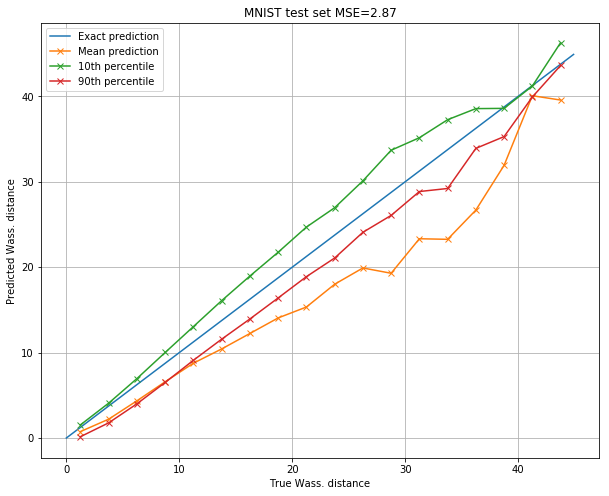

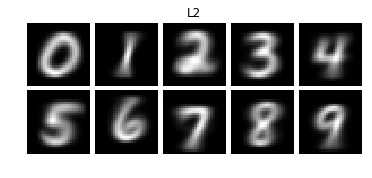

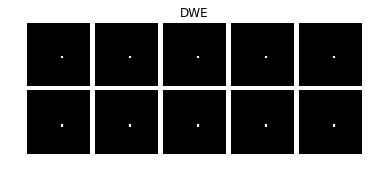

In [11]:
CUDA = True
DST_CONFIG_DIR = 'mnist'
DST_BIG_DATA_DIR = '/pio/scratch/1/i233123/data_mnist'
LOG_FILE = 'stdout.txt'
CONFIG_FILE = 'config.txt'

# if os.path.exists(LOG_FILE):
#     os.remove(LOG_FILE)

# if not os.path.exists('/pio/scratch/1/i233123/'):
#     os.mkdir('/pio/scratch/1/i233123/')
        
def run_mnist(samples, learning_rate, batch_size, restore, train):
    global DST_CONFIG_DIR
    DST_CONFIG_DIR = ('%s/%.6f' % (DST_CONFIG_DIR, learning_rate)).replace(".", "#")
    (tr_i, tr_l, tr_d, v_i, v_l, v_d, ts_i, ts_l, ts_d) = load_mnist(samples)
#     printMatrixDistancesLabels(tr_d, tr_l, 10)
    
    model = CNN()
    if CUDA:
        model.cuda()

    if restore:
        loadModel(model)
    if train:
        trainModel(model, tr_i, tr_d, v_i, v_d, learning_rate, samples, batch_size, restore)
    model.eval()
    
    plotScatter('MNIST test set ', model, ts_i, ts_d, batch_size)
    plotBarycenters(model, ts_i, ts_l, 10)
    
run_mnist(1000000, 0.0005, 1000, True, True)

In [12]:
CUDA = True
DST_CONFIG_DIR = 'doodle'
DST_BIG_DATA_DIR = '/pio/scratch/1/i233123/data_doodle'
LOG_FILE = 'stdout.txt'
CONFIG_FILE = 'config.txt'

# if os.path.exists(LOG_FILE):
#     os.remove(LOG_FILE)

# if not os.path.exists('/pio/scratch/1/i233123/'):
#     os.mkdir('/pio/scratch/1/i233123/')
        
def run_doodle(samples, learning_rate, batch_size, restore, train):
    global DST_CONFIG_DIR
    DST_CONFIG_DIR = ('%s/%.6f' % (DST_CONFIG_DIR, learning_rate)).replace(".", "#")
    (tr_i, tr_l, tr_d, v_i, v_l, v_d, ts_i, ts_l, ts_d) = load_doodle(samples)
#     printMatrixDistancesLabels(tr_d, tr_l, 4)
        
    model = CNN()
    if CUDA:
        model.cuda()

    if restore:
        loadModel(model)
    if train:
        trainModel(model, tr_i, tr_d, v_i, v_d, learning_rate, samples, batch_size, restore)
    model.eval()
    
    plotScatter('Doodle test set ', model, ts_i, ts_d, batch_size)
    plotBarycenters(model, ts_i, ts_l, 4)
    
run_doodle(1000000, 0.0005, 1000, True, True)